In [34]:
%load_ext autoreload
%autoreload 2  

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
from torchsummary import summary

In [36]:
import matplotlib.pyplot as plt 

In [37]:
from torch.utils.tensorboard import SummaryWriter

In [38]:
import segmentation_models_pytorch as smp
import torch
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter


import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

from quickannotator.dl.inference import run_inference, getPendingInferenceTiles
from quickannotator.dl.dataset import TileDataset
import io
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
from safetensors.torch import save_file

def get_transforms(tile_size): #probably goes...elsewhere
    transforms = A.Compose([
    A.RandomScale(scale_limit=0.1, p=.9),
    A.PadIfNeeded(min_height=tile_size, min_width=tile_size),
    A.VerticalFlip(p=.5),
    A.HorizontalFlip(p=.5),
    # A.Blur(p=.5),
    # # Downscale(p=.25, scale_min=0.64, scale_max=0.99),
    A.GaussNoise(p=.5, var_limit=(10.0, 50.0)),
    # A.GridDistortion(p=.5, num_steps=5, distort_limit=(-0.3, 0.3),
    #                 border_mode=cv2.BORDER_REFLECT),
    A.ISONoise(p=.5, intensity=(0.1, 0.5), color_shift=(0.01, 0.05)),
    # A.RandomBrightnessContrast(p=0.5, brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), brightness_by_max=True),
    # A.RandomGamma(p=.5, gamma_limit=(80, 120), eps=1e-07),
    # A.MultiplicativeNoise(p=.5, multiplier=(0.9, 1.1), per_channel=True, elementwise=True),
    # A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=10, val_shift_limit=10, p=.9),
    A.Rotate(p=1, border_mode=cv2.BORDER_REFLECT),
    A.RandomCrop(tile_size, tile_size),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),  # Normalization
    ToTensorV2()])
    return transforms



In [39]:
classid = 2 
tile_size = 2_048 

boost_count = 5
batch_size_train=2
batch_size_infer=1
edge_weight=1_000
num_workers=0 

num_iters=50

dataset=TileDataset(classid, tile_size=tile_size, 
                    edge_weight=edge_weight, transforms=get_transforms(tile_size), 
                    boost_count=boost_count)

dataloader = DataLoader(dataset, batch_size=batch_size_train, shuffle=False, num_workers=num_workers) #NOTE: for dataset of type iter - shuffle must == False

model = smp.Unet(encoder_name="efficientnet-b0", encoder_weights="imagenet", 
                 decoder_channels=(64, 64, 64, 32, 16), in_channels=3, classes=1, encoder_freeze=True )
criterion = nn.BCEWithLogitsLoss(reduction='none', ).cuda()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-2) #TODO: this should be a setting

device = 'cuda' if torch.cuda.is_available() else "cpu"
model.to(device)
model.train()



/tmp/ipykernel_4019/3487456973.py:27: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(p=.5, var_limit=(10.0, 50.0)),


Unet(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          32, 8, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          8, 32, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStaticSamePadding

In [40]:
for param in model.encoder.parameters():
    param.requires_grad = False
    
for name, param in model.named_parameters():
    if not param.requires_grad:
        print(f"{name} is frozen")

encoder._conv_stem.weight is frozen
encoder._bn0.weight is frozen
encoder._bn0.bias is frozen
encoder._blocks.0._depthwise_conv.weight is frozen
encoder._blocks.0._bn1.weight is frozen
encoder._blocks.0._bn1.bias is frozen
encoder._blocks.0._se_reduce.weight is frozen
encoder._blocks.0._se_reduce.bias is frozen
encoder._blocks.0._se_expand.weight is frozen
encoder._blocks.0._se_expand.bias is frozen
encoder._blocks.0._project_conv.weight is frozen
encoder._blocks.0._bn2.weight is frozen
encoder._blocks.0._bn2.bias is frozen
encoder._blocks.1._expand_conv.weight is frozen
encoder._blocks.1._bn0.weight is frozen
encoder._blocks.1._bn0.bias is frozen
encoder._blocks.1._depthwise_conv.weight is frozen
encoder._blocks.1._bn1.weight is frozen
encoder._blocks.1._bn1.bias is frozen
encoder._blocks.1._se_reduce.weight is frozen
encoder._blocks.1._se_reduce.bias is frozen
encoder._blocks.1._se_expand.weight is frozen
encoder._blocks.1._se_expand.bias is frozen
encoder._blocks.1._project_conv.wei

In [41]:
_ = summary(model, (3, tile_size, tile_size)) #TODO: log this

Layer (type:depth-idx)                                  Output Shape              Param #
├─EfficientNetEncoder: 1-1                              [-1, 3, 2048, 2048]       --
|    └─Conv2dStaticSamePadding: 2-1                     [-1, 32, 1024, 1024]      --
|    |    └─ZeroPad2d: 3-1                              [-1, 3, 2049, 2049]       --
|    └─BatchNorm2d: 2-2                                 [-1, 32, 1024, 1024]      (64)
|    └─MemoryEfficientSwish: 2-3                        [-1, 32, 1024, 1024]      --
|    └─ModuleList: 2                                    []                        --
|    |    └─MBConvBlock: 3-2                            [-1, 16, 1024, 1024]      (1,448)
|    |    └─MBConvBlock: 3-3                            [-1, 24, 512, 512]        (6,004)
|    |    └─MBConvBlock: 3-4                            [-1, 24, 512, 512]        (10,710)
|    |    └─MBConvBlock: 3-5                            [-1, 40, 256, 256]        (15,350)
|    |    └─MBConvBlock: 3-6        

In [42]:
import datetime
running_loss = []
writer = SummaryWriter(log_dir=f"/tmp/{classid}/{datetime.datetime.now().strftime('%b%d_%H-%M-%S')}")

scaler = torch.amp.GradScaler("cuda")


for niter in tqdm(range(num_iters)): #TODO: this should be a setting
    images, masks, weights = next(iter(dataloader))
    #print ("post next iter")
    images = images.to(device)
    masks = masks.to(device)
    weights = weights.to(device)
    #print ("post copy ")
    for _ in tqdm(range(5)):
        
        with torch.autocast(device_type="cuda", dtype=torch.float16):
            outputs = model(images)

            loss = criterion(outputs, masks.float())
            loss = (loss * (edge_weight ** weights).type_as(loss)).mean()

            positive_mask = (masks == 1).float()
            unlabeled_mask = (masks == 0).float()

            positive_loss = 1.0 * (loss * positive_mask).mean()
            unlabeled_loss = .1 * (loss * unlabeled_mask).mean()

            loss_total = positive_loss + unlabeled_loss
        #loss_total.backward()
        scaler.scale(loss_total).backward()

        #optimizer.step()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()
        
    running_loss.append(loss_total.item())

    writer.add_scalar(f'loss/loss', loss, niter)
    writer.add_scalar(f'loss/positive_loss', positive_loss, niter)
    writer.add_scalar(f'loss/unlabeled_loss', unlabeled_loss, niter)
    writer.add_scalar(f'loss/loss_total', loss_total, niter)
    
    print ("losses:\t",loss_total,positive_mask.sum(),positive_loss,unlabeled_loss)

    
    if niter % 50==0:
        print (f"niter [{niter}], Loss: {sum(running_loss)/len(running_loss)}")
        running_loss=[]

        print ("saving!") #TODO: do we want to *always* override the last saved model , or do we want to instead only save if some type of loss threshold is met?
                            #another potentially more interesting option is to do both, save on a regular basis (since if we things crash we can revert back othe nearest checkpoint\
                            #but as well give the user in the front end a dropdown which enables them to select which model checkpoint they want to use? we had somethng similar in QAv1
                            #that said, this is likely a more advanced features and not very "apple like" since it would require explaining to the user when/why/how they should use the different models
                            #maybe suggest avoiduing for now --- lets just save the last one
        save_file(model.state_dict(), f"/tmp/model_{classid}.safetensors") #TODO: needs to go somewhere reasonable maybe /projid/models/classid/ ? or something
        last_save = 0



  0%|          | 0/50 [00:00<?, ?it/s]

tile retval <quickannotator.db.models.Tile object at 0x7feb2aaa4c70>
tile retval 2 <quickannotator.db.models.Tile object at 0x7feb2aaa4c70>
tile retval <quickannotator.db.models.Tile object at 0x7feb2aabb790>
tile retval 2 <quickannotator.db.models.Tile object at 0x7feb2aabb790>


  2%|▏         | 1/50 [00:04<03:33,  4.35s/it]

losses:	 tensor(0.1831, device='cuda:0', grad_fn=<AddBackward0>) tensor(2474692., device='cuda:0') tensor(0.1479, device='cuda:0', grad_fn=<MulBackward0>) tensor(0.0352, device='cuda:0', grad_fn=<MulBackward0>)
niter [0], Loss: 0.18311306834220886
saving!
tile retval <quickannotator.db.models.Tile object at 0x7feb2aae3280>
tile retval 2 <quickannotator.db.models.Tile object at 0x7feb2aae3280>
tile retval <quickannotator.db.models.Tile object at 0x7feb2aae0cd0>
tile retval 2 <quickannotator.db.models.Tile object at 0x7feb2aae0cd0>


  4%|▍         | 2/50 [00:08<03:16,  4.10s/it]

losses:	 tensor(0.1299, device='cuda:0', grad_fn=<AddBackward0>) tensor(2097264., device='cuda:0') tensor(0.1001, device='cuda:0', grad_fn=<MulBackward0>) tensor(0.0299, device='cuda:0', grad_fn=<MulBackward0>)
tile retval <quickannotator.db.models.Tile object at 0x7feb2aaee350>
tile retval 2 <quickannotator.db.models.Tile object at 0x7feb2aaee350>
tile retval <quickannotator.db.models.Tile object at 0x7feb2aaef1c0>
tile retval 2 <quickannotator.db.models.Tile object at 0x7feb2aaef1c0>


  6%|▌         | 3/50 [00:12<03:20,  4.27s/it]

losses:	 tensor(0.1045, device='cuda:0', grad_fn=<AddBackward0>) tensor(1720032., device='cuda:0') tensor(0.0754, device='cuda:0', grad_fn=<MulBackward0>) tensor(0.0291, device='cuda:0', grad_fn=<MulBackward0>)
tile retval <quickannotator.db.models.Tile object at 0x7feb2aae2800>
tile retval 2 <quickannotator.db.models.Tile object at 0x7feb2aae2800>
tile retval <quickannotator.db.models.Tile object at 0x7feb2aa34ee0>
tile retval 2 <quickannotator.db.models.Tile object at 0x7feb2aa34ee0>


  8%|▊         | 4/50 [00:18<03:52,  5.04s/it]

losses:	 tensor(0.1097, device='cuda:0', grad_fn=<AddBackward0>) tensor(2204944., device='cuda:0') tensor(0.0858, device='cuda:0', grad_fn=<MulBackward0>) tensor(0.0240, device='cuda:0', grad_fn=<MulBackward0>)
tile retval <quickannotator.db.models.Tile object at 0x7feb2adf3c10>
tile retval 2 <quickannotator.db.models.Tile object at 0x7feb2adf3c10>
tile retval <quickannotator.db.models.Tile object at 0x7feb2aab84c0>
tile retval 2 <quickannotator.db.models.Tile object at 0x7feb2aab84c0>


 10%|█         | 5/50 [00:22<03:28,  4.64s/it]

losses:	 tensor(0.0589, device='cuda:0', grad_fn=<AddBackward0>) tensor(1283858., device='cuda:0') tensor(0.0380, device='cuda:0', grad_fn=<MulBackward0>) tensor(0.0210, device='cuda:0', grad_fn=<MulBackward0>)
tile retval <quickannotator.db.models.Tile object at 0x7feb2a8a5660>
tile retval 2 <quickannotator.db.models.Tile object at 0x7feb2a8a5660>
tile retval <quickannotator.db.models.Tile object at 0x7feb2a8a6110>
tile retval 2 <quickannotator.db.models.Tile object at 0x7feb2a8a6110>


 12%|█▏        | 6/50 [00:26<03:10,  4.33s/it]

losses:	 tensor(0.0624, device='cuda:0', grad_fn=<AddBackward0>) tensor(1452239., device='cuda:0') tensor(0.0423, device='cuda:0', grad_fn=<MulBackward0>) tensor(0.0201, device='cuda:0', grad_fn=<MulBackward0>)
tile retval <quickannotator.db.models.Tile object at 0x7feb2a8643a0>
tile retval 2 <quickannotator.db.models.Tile object at 0x7feb2a8643a0>
tile retval <quickannotator.db.models.Tile object at 0x7feb2a866bf0>
tile retval 2 <quickannotator.db.models.Tile object at 0x7feb2a866bf0>


 14%|█▍        | 7/50 [00:31<03:17,  4.60s/it]

losses:	 tensor(0.0841, device='cuda:0', grad_fn=<AddBackward0>) tensor(2239798., device='cuda:0') tensor(0.0660, device='cuda:0', grad_fn=<MulBackward0>) tensor(0.0181, device='cuda:0', grad_fn=<MulBackward0>)
tile retval <quickannotator.db.models.Tile object at 0x7feb30236e00>
tile retval 2 <quickannotator.db.models.Tile object at 0x7feb30236e00>
tile retval <quickannotator.db.models.Tile object at 0x7feb2a9093f0>
tile retval 2 <quickannotator.db.models.Tile object at 0x7feb2a9093f0>


 16%|█▌        | 8/50 [00:35<03:04,  4.39s/it]

losses:	 tensor(0.0559, device='cuda:0', grad_fn=<AddBackward0>) tensor(1625239., device='cuda:0') tensor(0.0395, device='cuda:0', grad_fn=<MulBackward0>) tensor(0.0164, device='cuda:0', grad_fn=<MulBackward0>)
tile retval <quickannotator.db.models.Tile object at 0x7feb2aae19f0>
tile retval 2 <quickannotator.db.models.Tile object at 0x7feb2aae19f0>
tile retval <quickannotator.db.models.Tile object at 0x7feb2873b160>
tile retval 2 <quickannotator.db.models.Tile object at 0x7feb2873b160>


 18%|█▊        | 9/50 [00:39<02:51,  4.17s/it]

losses:	 tensor(0.0514, device='cuda:0', grad_fn=<AddBackward0>) tensor(1234816., device='cuda:0') tensor(0.0325, device='cuda:0', grad_fn=<MulBackward0>) tensor(0.0188, device='cuda:0', grad_fn=<MulBackward0>)
tile retval <quickannotator.db.models.Tile object at 0x7feb287194e0>
tile retval 2 <quickannotator.db.models.Tile object at 0x7feb287194e0>
tile retval <quickannotator.db.models.Tile object at 0x7feb28719cc0>
tile retval 2 <quickannotator.db.models.Tile object at 0x7feb28719cc0>


 20%|██        | 10/50 [00:42<02:35,  3.89s/it]

losses:	 tensor(0.0339, device='cuda:0', grad_fn=<AddBackward0>) tensor(442365., device='cuda:0') tensor(0.0121, device='cuda:0', grad_fn=<MulBackward0>) tensor(0.0218, device='cuda:0', grad_fn=<MulBackward0>)
tile retval <quickannotator.db.models.Tile object at 0x7feb2aa35540>
tile retval 2 <quickannotator.db.models.Tile object at 0x7feb2aa35540>
tile retval <quickannotator.db.models.Tile object at 0x7feb2a8a69e0>
tile retval 2 <quickannotator.db.models.Tile object at 0x7feb2a8a69e0>


 22%|██▏       | 11/50 [00:46<02:34,  3.96s/it]

losses:	 tensor(0.0877, device='cuda:0', grad_fn=<AddBackward0>) tensor(2129638., device='cuda:0') tensor(0.0678, device='cuda:0', grad_fn=<MulBackward0>) tensor(0.0198, device='cuda:0', grad_fn=<MulBackward0>)
tile retval <quickannotator.db.models.Tile object at 0x7feba37d36a0>
tile retval 2 <quickannotator.db.models.Tile object at 0x7feba37d36a0>
tile retval <quickannotator.db.models.Tile object at 0x7feb2a8a7220>
tile retval 2 <quickannotator.db.models.Tile object at 0x7feb2a8a7220>


 24%|██▍       | 12/50 [00:50<02:29,  3.93s/it]

losses:	 tensor(0.0324, device='cuda:0', grad_fn=<AddBackward0>) tensor(757200., device='cuda:0') tensor(0.0161, device='cuda:0', grad_fn=<MulBackward0>) tensor(0.0162, device='cuda:0', grad_fn=<MulBackward0>)
tile retval <quickannotator.db.models.Tile object at 0x7feb287bdc00>
tile retval 2 <quickannotator.db.models.Tile object at 0x7feb287bdc00>
tile retval <quickannotator.db.models.Tile object at 0x7feb287bd870>
tile retval 2 <quickannotator.db.models.Tile object at 0x7feb287bd870>


 26%|██▌       | 13/50 [00:54<02:26,  3.95s/it]

losses:	 tensor(0.0230, device='cuda:0', grad_fn=<AddBackward0>) tensor(49820., device='cuda:0') tensor(0.0013, device='cuda:0', grad_fn=<MulBackward0>) tensor(0.0217, device='cuda:0', grad_fn=<MulBackward0>)
tile retval <quickannotator.db.models.Tile object at 0x7feb301419c0>
tile retval 2 <quickannotator.db.models.Tile object at 0x7feb301419c0>
tile retval <quickannotator.db.models.Tile object at 0x7feb2a90af80>
tile retval 2 <quickannotator.db.models.Tile object at 0x7feb2a90af80>


 28%|██▊       | 14/50 [00:59<02:34,  4.30s/it]

losses:	 tensor(0.0777, device='cuda:0', grad_fn=<AddBackward0>) tensor(1878619., device='cuda:0') tensor(0.0577, device='cuda:0', grad_fn=<MulBackward0>) tensor(0.0199, device='cuda:0', grad_fn=<MulBackward0>)
tile retval <quickannotator.db.models.Tile object at 0x7feb2871ac20>
tile retval 2 <quickannotator.db.models.Tile object at 0x7feb2871ac20>
tile retval <quickannotator.db.models.Tile object at 0x7feb2871b130>
tile retval 2 <quickannotator.db.models.Tile object at 0x7feb2871b130>


 30%|███       | 15/50 [01:04<02:33,  4.37s/it]

losses:	 tensor(0.0509, device='cuda:0', grad_fn=<AddBackward0>) tensor(1687217., device='cuda:0') tensor(0.0365, device='cuda:0', grad_fn=<MulBackward0>) tensor(0.0144, device='cuda:0', grad_fn=<MulBackward0>)
tile retval <quickannotator.db.models.Tile object at 0x7febfb4a6a70>
tile retval 2 <quickannotator.db.models.Tile object at 0x7febfb4a6a70>
tile retval <quickannotator.db.models.Tile object at 0x7feb286443d0>
tile retval 2 <quickannotator.db.models.Tile object at 0x7feb286443d0>


 32%|███▏      | 16/50 [01:08<02:23,  4.22s/it]

losses:	 tensor(0.0794, device='cuda:0', grad_fn=<AddBackward0>) tensor(1823371., device='cuda:0') tensor(0.0584, device='cuda:0', grad_fn=<MulBackward0>) tensor(0.0210, device='cuda:0', grad_fn=<MulBackward0>)
tile retval <quickannotator.db.models.Tile object at 0x7feba37d2320>
tile retval 2 <quickannotator.db.models.Tile object at 0x7feba37d2320>
tile retval <quickannotator.db.models.Tile object at 0x7feb9fdea260>
tile retval 2 <quickannotator.db.models.Tile object at 0x7feb9fdea260>


 34%|███▍      | 17/50 [01:12<02:19,  4.23s/it]

losses:	 tensor(0.0845, device='cuda:0', grad_fn=<AddBackward0>) tensor(2130461., device='cuda:0') tensor(0.0654, device='cuda:0', grad_fn=<MulBackward0>) tensor(0.0191, device='cuda:0', grad_fn=<MulBackward0>)
tile retval <quickannotator.db.models.Tile object at 0x7febfb4a6ad0>
tile retval 2 <quickannotator.db.models.Tile object at 0x7febfb4a6ad0>
tile retval <quickannotator.db.models.Tile object at 0x7feb28645450>
tile retval 2 <quickannotator.db.models.Tile object at 0x7feb28645450>


 36%|███▌      | 18/50 [01:16<02:18,  4.33s/it]

losses:	 tensor(0.0878, device='cuda:0', grad_fn=<AddBackward0>) tensor(2366627., device='cuda:0') tensor(0.0701, device='cuda:0', grad_fn=<MulBackward0>) tensor(0.0178, device='cuda:0', grad_fn=<MulBackward0>)
tile retval <quickannotator.db.models.Tile object at 0x7feb286a66b0>
tile retval 2 <quickannotator.db.models.Tile object at 0x7feb286a66b0>
tile retval <quickannotator.db.models.Tile object at 0x7feb286a6c80>
tile retval 2 <quickannotator.db.models.Tile object at 0x7feb286a6c80>


 38%|███▊      | 19/50 [01:21<02:14,  4.34s/it]

losses:	 tensor(0.0393, device='cuda:0', grad_fn=<AddBackward0>) tensor(1433417., device='cuda:0') tensor(0.0265, device='cuda:0', grad_fn=<MulBackward0>) tensor(0.0128, device='cuda:0', grad_fn=<MulBackward0>)
tile retval <quickannotator.db.models.Tile object at 0x7feb2ac51d20>
tile retval 2 <quickannotator.db.models.Tile object at 0x7feb2ac51d20>
tile retval <quickannotator.db.models.Tile object at 0x7feb28646350>
tile retval 2 <quickannotator.db.models.Tile object at 0x7feb28646350>


 40%|████      | 20/50 [01:26<02:13,  4.45s/it]

losses:	 tensor(0.0655, device='cuda:0', grad_fn=<AddBackward0>) tensor(1435944., device='cuda:0') tensor(0.0441, device='cuda:0', grad_fn=<MulBackward0>) tensor(0.0213, device='cuda:0', grad_fn=<MulBackward0>)
tile retval <quickannotator.db.models.Tile object at 0x7feb286dfee0>
tile retval 2 <quickannotator.db.models.Tile object at 0x7feb286dfee0>
tile retval <quickannotator.db.models.Tile object at 0x7feb286dcc70>
tile retval 2 <quickannotator.db.models.Tile object at 0x7feb286dcc70>


 42%|████▏     | 21/50 [01:32<02:25,  5.03s/it]

losses:	 tensor(0.0693, device='cuda:0', grad_fn=<AddBackward0>) tensor(1986631., device='cuda:0') tensor(0.0525, device='cuda:0', grad_fn=<MulBackward0>) tensor(0.0169, device='cuda:0', grad_fn=<MulBackward0>)
tile retval <quickannotator.db.models.Tile object at 0x7feb2866dfc0>
tile retval 2 <quickannotator.db.models.Tile object at 0x7feb2866dfc0>
tile retval <quickannotator.db.models.Tile object at 0x7feb286ef6d0>
tile retval 2 <quickannotator.db.models.Tile object at 0x7feb286ef6d0>


 44%|████▍     | 22/50 [01:36<02:15,  4.84s/it]

losses:	 tensor(0.0475, device='cuda:0', grad_fn=<AddBackward0>) tensor(1616899., device='cuda:0') tensor(0.0335, device='cuda:0', grad_fn=<MulBackward0>) tensor(0.0140, device='cuda:0', grad_fn=<MulBackward0>)
tile retval <quickannotator.db.models.Tile object at 0x7feb2851d870>
tile retval 2 <quickannotator.db.models.Tile object at 0x7feb2851d870>
tile retval <quickannotator.db.models.Tile object at 0x7feb2851c190>
tile retval 2 <quickannotator.db.models.Tile object at 0x7feb2851c190>


 46%|████▌     | 23/50 [01:41<02:12,  4.92s/it]

losses:	 tensor(0.0773, device='cuda:0', grad_fn=<AddBackward0>) tensor(2249727., device='cuda:0') tensor(0.0608, device='cuda:0', grad_fn=<MulBackward0>) tensor(0.0165, device='cuda:0', grad_fn=<MulBackward0>)
tile retval <quickannotator.db.models.Tile object at 0x7feb286dfa90>
tile retval 2 <quickannotator.db.models.Tile object at 0x7feb286dfa90>
tile retval <quickannotator.db.models.Tile object at 0x7feb28513580>
tile retval 2 <quickannotator.db.models.Tile object at 0x7feb28513580>


 48%|████▊     | 24/50 [01:45<02:00,  4.65s/it]

losses:	 tensor(0.0210, device='cuda:0', grad_fn=<AddBackward0>) tensor(343396., device='cuda:0') tensor(0.0063, device='cuda:0', grad_fn=<MulBackward0>) tensor(0.0147, device='cuda:0', grad_fn=<MulBackward0>)
tile retval <quickannotator.db.models.Tile object at 0x7feb28510c40>
tile retval 2 <quickannotator.db.models.Tile object at 0x7feb28510c40>
tile retval <quickannotator.db.models.Tile object at 0x7feb28510a60>
tile retval 2 <quickannotator.db.models.Tile object at 0x7feb28510a60>


 50%|█████     | 25/50 [01:50<01:54,  4.59s/it]

losses:	 tensor(0.0445, device='cuda:0', grad_fn=<AddBackward0>) tensor(1595747., device='cuda:0') tensor(0.0313, device='cuda:0', grad_fn=<MulBackward0>) tensor(0.0133, device='cuda:0', grad_fn=<MulBackward0>)
tile retval <quickannotator.db.models.Tile object at 0x7feb286ee680>
tile retval 2 <quickannotator.db.models.Tile object at 0x7feb286ee680>
tile retval <quickannotator.db.models.Tile object at 0x7feb286ef2e0>
tile retval 2 <quickannotator.db.models.Tile object at 0x7feb286ef2e0>


 52%|█████▏    | 26/50 [01:54<01:48,  4.51s/it]

losses:	 tensor(0.0751, device='cuda:0', grad_fn=<AddBackward0>) tensor(1786839., device='cuda:0') tensor(0.0549, device='cuda:0', grad_fn=<MulBackward0>) tensor(0.0202, device='cuda:0', grad_fn=<MulBackward0>)
tile retval <quickannotator.db.models.Tile object at 0x7feb2858aad0>
tile retval 2 <quickannotator.db.models.Tile object at 0x7feb2858aad0>
tile retval <quickannotator.db.models.Tile object at 0x7feb28589240>
tile retval 2 <quickannotator.db.models.Tile object at 0x7feb28589240>


 54%|█████▍    | 27/50 [01:58<01:38,  4.27s/it]

losses:	 tensor(0.0135, device='cuda:0', grad_fn=<AddBackward0>) tensor(102461., device='cuda:0') tensor(0.0015, device='cuda:0', grad_fn=<MulBackward0>) tensor(0.0120, device='cuda:0', grad_fn=<MulBackward0>)
tile retval <quickannotator.db.models.Tile object at 0x7feb285886a0>
tile retval 2 <quickannotator.db.models.Tile object at 0x7feb285886a0>
tile retval <quickannotator.db.models.Tile object at 0x7feb286ec670>
tile retval 2 <quickannotator.db.models.Tile object at 0x7feb286ec670>


 56%|█████▌    | 28/50 [02:03<01:41,  4.61s/it]

losses:	 tensor(0.0368, device='cuda:0', grad_fn=<AddBackward0>) tensor(1515477., device='cuda:0') tensor(0.0254, device='cuda:0', grad_fn=<MulBackward0>) tensor(0.0115, device='cuda:0', grad_fn=<MulBackward0>)
tile retval <quickannotator.db.models.Tile object at 0x7feb2840ee60>
tile retval 2 <quickannotator.db.models.Tile object at 0x7feb2840ee60>
tile retval <quickannotator.db.models.Tile object at 0x7feb2840fac0>
tile retval 2 <quickannotator.db.models.Tile object at 0x7feb2840fac0>


 58%|█████▊    | 29/50 [02:07<01:30,  4.33s/it]

losses:	 tensor(0.0442, device='cuda:0', grad_fn=<AddBackward0>) tensor(1261835., device='cuda:0') tensor(0.0282, device='cuda:0', grad_fn=<MulBackward0>) tensor(0.0159, device='cuda:0', grad_fn=<MulBackward0>)
tile retval <quickannotator.db.models.Tile object at 0x7feb2840cd90>
tile retval 2 <quickannotator.db.models.Tile object at 0x7feb2840cd90>
tile retval <quickannotator.db.models.Tile object at 0x7feb28442530>
tile retval 2 <quickannotator.db.models.Tile object at 0x7feb28442530>


 60%|██████    | 30/50 [02:12<01:29,  4.48s/it]

losses:	 tensor(0.0659, device='cuda:0', grad_fn=<AddBackward0>) tensor(2027442., device='cuda:0') tensor(0.0502, device='cuda:0', grad_fn=<MulBackward0>) tensor(0.0157, device='cuda:0', grad_fn=<MulBackward0>)
tile retval <quickannotator.db.models.Tile object at 0x7feb28440550>
tile retval 2 <quickannotator.db.models.Tile object at 0x7feb28440550>
tile retval <quickannotator.db.models.Tile object at 0x7feb28440d90>
tile retval 2 <quickannotator.db.models.Tile object at 0x7feb28440d90>


 62%|██████▏   | 31/50 [02:17<01:27,  4.61s/it]

losses:	 tensor(0.0720, device='cuda:0', grad_fn=<AddBackward0>) tensor(2060296., device='cuda:0') tensor(0.0552, device='cuda:0', grad_fn=<MulBackward0>) tensor(0.0169, device='cuda:0', grad_fn=<MulBackward0>)
tile retval <quickannotator.db.models.Tile object at 0x7feb2844a3b0>
tile retval 2 <quickannotator.db.models.Tile object at 0x7feb2844a3b0>
tile retval <quickannotator.db.models.Tile object at 0x7feb2844ab60>
tile retval 2 <quickannotator.db.models.Tile object at 0x7feb2844ab60>


 64%|██████▍   | 32/50 [02:22<01:23,  4.65s/it]

losses:	 tensor(0.0626, device='cuda:0', grad_fn=<AddBackward0>) tensor(2158261., device='cuda:0') tensor(0.0486, device='cuda:0', grad_fn=<MulBackward0>) tensor(0.0140, device='cuda:0', grad_fn=<MulBackward0>)
tile retval <quickannotator.db.models.Tile object at 0x7feb284d23b0>
tile retval 2 <quickannotator.db.models.Tile object at 0x7feb284d23b0>
tile retval <quickannotator.db.models.Tile object at 0x7feb284d2ec0>
tile retval 2 <quickannotator.db.models.Tile object at 0x7feb284d2ec0>


 66%|██████▌   | 33/50 [02:27<01:21,  4.78s/it]

losses:	 tensor(0.0760, device='cuda:0', grad_fn=<AddBackward0>) tensor(2178816., device='cuda:0') tensor(0.0592, device='cuda:0', grad_fn=<MulBackward0>) tensor(0.0168, device='cuda:0', grad_fn=<MulBackward0>)
tile retval <quickannotator.db.models.Tile object at 0x7feb284dcfd0>
tile retval 2 <quickannotator.db.models.Tile object at 0x7feb284dcfd0>
tile retval <quickannotator.db.models.Tile object at 0x7feb284dded0>
tile retval 2 <quickannotator.db.models.Tile object at 0x7feb284dded0>


 68%|██████▊   | 34/50 [02:32<01:20,  5.00s/it]

losses:	 tensor(0.0443, device='cuda:0', grad_fn=<AddBackward0>) tensor(1428399., device='cuda:0') tensor(0.0298, device='cuda:0', grad_fn=<MulBackward0>) tensor(0.0145, device='cuda:0', grad_fn=<MulBackward0>)
tile retval <quickannotator.db.models.Tile object at 0x7feb28483b20>
tile retval 2 <quickannotator.db.models.Tile object at 0x7feb28483b20>
tile retval <quickannotator.db.models.Tile object at 0x7feb28480610>
tile retval 2 <quickannotator.db.models.Tile object at 0x7feb28480610>


 70%|███████   | 35/50 [02:36<01:09,  4.61s/it]

losses:	 tensor(0.0523, device='cuda:0', grad_fn=<AddBackward0>) tensor(1447065., device='cuda:0') tensor(0.0354, device='cuda:0', grad_fn=<MulBackward0>) tensor(0.0169, device='cuda:0', grad_fn=<MulBackward0>)
tile retval <quickannotator.db.models.Tile object at 0x7feb313ba770>
tile retval 2 <quickannotator.db.models.Tile object at 0x7feb313ba770>
tile retval <quickannotator.db.models.Tile object at 0x7feb284d3340>
tile retval 2 <quickannotator.db.models.Tile object at 0x7feb284d3340>


 72%|███████▏  | 36/50 [02:41<01:06,  4.75s/it]

losses:	 tensor(0.1061, device='cuda:0', grad_fn=<AddBackward0>) tensor(2681234., device='cuda:0') tensor(0.0876, device='cuda:0', grad_fn=<MulBackward0>) tensor(0.0185, device='cuda:0', grad_fn=<MulBackward0>)
tile retval <quickannotator.db.models.Tile object at 0x7feb284dc280>
tile retval 2 <quickannotator.db.models.Tile object at 0x7feb284dc280>
tile retval <quickannotator.db.models.Tile object at 0x7feb284804f0>
tile retval 2 <quickannotator.db.models.Tile object at 0x7feb284804f0>


 74%|███████▍  | 37/50 [02:45<01:01,  4.69s/it]

losses:	 tensor(0.0479, device='cuda:0', grad_fn=<AddBackward0>) tensor(1559782., device='cuda:0') tensor(0.0333, device='cuda:0', grad_fn=<MulBackward0>) tensor(0.0146, device='cuda:0', grad_fn=<MulBackward0>)
tile retval <quickannotator.db.models.Tile object at 0x7feb28310be0>
tile retval 2 <quickannotator.db.models.Tile object at 0x7feb28310be0>
tile retval <quickannotator.db.models.Tile object at 0x7feb283111e0>
tile retval 2 <quickannotator.db.models.Tile object at 0x7feb283111e0>


 76%|███████▌  | 38/50 [02:50<00:55,  4.62s/it]

losses:	 tensor(0.0375, device='cuda:0', grad_fn=<AddBackward0>) tensor(1182421., device='cuda:0') tensor(0.0233, device='cuda:0', grad_fn=<MulBackward0>) tensor(0.0142, device='cuda:0', grad_fn=<MulBackward0>)
tile retval <quickannotator.db.models.Tile object at 0x7feb283465f0>
tile retval 2 <quickannotator.db.models.Tile object at 0x7feb283465f0>
tile retval <quickannotator.db.models.Tile object at 0x7feb283475b0>
tile retval 2 <quickannotator.db.models.Tile object at 0x7feb283475b0>


 78%|███████▊  | 39/50 [02:55<00:53,  4.83s/it]

losses:	 tensor(0.0149, device='cuda:0', grad_fn=<AddBackward0>) tensor(446753., device='cuda:0') tensor(0.0054, device='cuda:0', grad_fn=<MulBackward0>) tensor(0.0095, device='cuda:0', grad_fn=<MulBackward0>)
tile retval <quickannotator.db.models.Tile object at 0x7feb28311d20>
tile retval 2 <quickannotator.db.models.Tile object at 0x7feb28311d20>
tile retval <quickannotator.db.models.Tile object at 0x7feb28313400>
tile retval 2 <quickannotator.db.models.Tile object at 0x7feb28313400>


 80%|████████  | 40/50 [03:01<00:50,  5.01s/it]

losses:	 tensor(0.0782, device='cuda:0', grad_fn=<AddBackward0>) tensor(1967692., device='cuda:0') tensor(0.0590, device='cuda:0', grad_fn=<MulBackward0>) tensor(0.0192, device='cuda:0', grad_fn=<MulBackward0>)
tile retval <quickannotator.db.models.Tile object at 0x7feb28344e20>
tile retval 2 <quickannotator.db.models.Tile object at 0x7feb28344e20>
tile retval <quickannotator.db.models.Tile object at 0x7feb283ba680>
tile retval 2 <quickannotator.db.models.Tile object at 0x7feb283ba680>


 82%|████████▏ | 41/50 [03:05<00:43,  4.79s/it]

losses:	 tensor(0.0252, device='cuda:0', grad_fn=<AddBackward0>) tensor(749050., device='cuda:0') tensor(0.0125, device='cuda:0', grad_fn=<MulBackward0>) tensor(0.0127, device='cuda:0', grad_fn=<MulBackward0>)
tile retval <quickannotator.db.models.Tile object at 0x7feb28243fa0>
tile retval 2 <quickannotator.db.models.Tile object at 0x7feb28243fa0>
tile retval <quickannotator.db.models.Tile object at 0x7feb28242050>
tile retval 2 <quickannotator.db.models.Tile object at 0x7feb28242050>


 84%|████████▍ | 42/50 [03:09<00:35,  4.49s/it]

losses:	 tensor(0.0297, device='cuda:0', grad_fn=<AddBackward0>) tensor(0., device='cuda:0') tensor(0., device='cuda:0', grad_fn=<MulBackward0>) tensor(0.0297, device='cuda:0', grad_fn=<MulBackward0>)
tile retval <quickannotator.db.models.Tile object at 0x7feb283bb1f0>
tile retval 2 <quickannotator.db.models.Tile object at 0x7feb283bb1f0>
tile retval <quickannotator.db.models.Tile object at 0x7feb283baa40>
tile retval 2 <quickannotator.db.models.Tile object at 0x7feb283baa40>


 86%|████████▌ | 43/50 [03:13<00:30,  4.38s/it]

losses:	 tensor(0.0687, device='cuda:0', grad_fn=<AddBackward0>) tensor(1961857., device='cuda:0') tensor(0.0518, device='cuda:0', grad_fn=<MulBackward0>) tensor(0.0169, device='cuda:0', grad_fn=<MulBackward0>)
tile retval <quickannotator.db.models.Tile object at 0x7feb2827eda0>
tile retval 2 <quickannotator.db.models.Tile object at 0x7feb2827eda0>
tile retval <quickannotator.db.models.Tile object at 0x7feb2827c670>
tile retval 2 <quickannotator.db.models.Tile object at 0x7feb2827c670>


 88%|████████▊ | 44/50 [03:17<00:25,  4.31s/it]

losses:	 tensor(0.0681, device='cuda:0', grad_fn=<AddBackward0>) tensor(2014208., device='cuda:0') tensor(0.0518, device='cuda:0', grad_fn=<MulBackward0>) tensor(0.0163, device='cuda:0', grad_fn=<MulBackward0>)
tile retval <quickannotator.db.models.Tile object at 0x7feb282c7520>
tile retval 2 <quickannotator.db.models.Tile object at 0x7feb282c7520>
tile retval <quickannotator.db.models.Tile object at 0x7feb282c4d30>
tile retval 2 <quickannotator.db.models.Tile object at 0x7feb282c4d30>


 90%|█████████ | 45/50 [03:21<00:21,  4.32s/it]

losses:	 tensor(0.0552, device='cuda:0', grad_fn=<AddBackward0>) tensor(1589312., device='cuda:0') tensor(0.0387, device='cuda:0', grad_fn=<MulBackward0>) tensor(0.0165, device='cuda:0', grad_fn=<MulBackward0>)
tile retval <quickannotator.db.models.Tile object at 0x7feb282a13c0>
tile retval 2 <quickannotator.db.models.Tile object at 0x7feb282a13c0>
tile retval <quickannotator.db.models.Tile object at 0x7feb282a20b0>
tile retval 2 <quickannotator.db.models.Tile object at 0x7feb282a20b0>


 92%|█████████▏| 46/50 [03:28<00:20,  5.08s/it]

losses:	 tensor(0.0682, device='cuda:0', grad_fn=<AddBackward0>) tensor(1954945., device='cuda:0') tensor(0.0513, device='cuda:0', grad_fn=<MulBackward0>) tensor(0.0168, device='cuda:0', grad_fn=<MulBackward0>)
tile retval <quickannotator.db.models.Tile object at 0x7feb282089a0>
tile retval 2 <quickannotator.db.models.Tile object at 0x7feb282089a0>
tile retval <quickannotator.db.models.Tile object at 0x7feb282092d0>
tile retval 2 <quickannotator.db.models.Tile object at 0x7feb282092d0>


 94%|█████████▍| 47/50 [03:33<00:14,  4.99s/it]

losses:	 tensor(0.0770, device='cuda:0', grad_fn=<AddBackward0>) tensor(2436119., device='cuda:0') tensor(0.0620, device='cuda:0', grad_fn=<MulBackward0>) tensor(0.0151, device='cuda:0', grad_fn=<MulBackward0>)
tile retval <quickannotator.db.models.Tile object at 0x7feb282c64d0>
tile retval 2 <quickannotator.db.models.Tile object at 0x7feb282c64d0>
tile retval <quickannotator.db.models.Tile object at 0x7feb282c6d70>
tile retval 2 <quickannotator.db.models.Tile object at 0x7feb282c6d70>


 96%|█████████▌| 48/50 [03:36<00:09,  4.51s/it]

losses:	 tensor(0.0336, device='cuda:0', grad_fn=<AddBackward0>) tensor(1508848., device='cuda:0') tensor(0.0231, device='cuda:0', grad_fn=<MulBackward0>) tensor(0.0105, device='cuda:0', grad_fn=<MulBackward0>)
tile retval <quickannotator.db.models.Tile object at 0x7feb9fdd1360>
tile retval 2 <quickannotator.db.models.Tile object at 0x7feb9fdd1360>
tile retval <quickannotator.db.models.Tile object at 0x7feb282d5960>
tile retval 2 <quickannotator.db.models.Tile object at 0x7feb282d5960>


 98%|█████████▊| 49/50 [03:41<00:04,  4.49s/it]

losses:	 tensor(0.0550, device='cuda:0', grad_fn=<AddBackward0>) tensor(1635954., device='cuda:0') tensor(0.0389, device='cuda:0', grad_fn=<MulBackward0>) tensor(0.0160, device='cuda:0', grad_fn=<MulBackward0>)
tile retval <quickannotator.db.models.Tile object at 0x7feba37f88e0>
tile retval 2 <quickannotator.db.models.Tile object at 0x7feba37f88e0>
tile retval <quickannotator.db.models.Tile object at 0x7feb282a38b0>
tile retval 2 <quickannotator.db.models.Tile object at 0x7feb282a38b0>


100%|██████████| 50/50 [03:46<00:00,  4.52s/it]

losses:	 tensor(0.0578, device='cuda:0', grad_fn=<AddBackward0>) tensor(1846166., device='cuda:0') tensor(0.0428, device='cuda:0', grad_fn=<MulBackward0>) tensor(0.0151, device='cuda:0', grad_fn=<MulBackward0>)


In [43]:
images.shape

torch.Size([2, 3, 2048, 2048])

In [44]:
tds=TileDataset(classid, tile_size=tile_size,
                    edge_weight=edge_weight, transforms=None, 
                    boost_count=boost_count)


tile retval <quickannotator.db.models.Tile object at 0x7feb2aaa4280>
tile retval 2 <quickannotator.db.models.Tile object at 0x7feb2aaa4280>


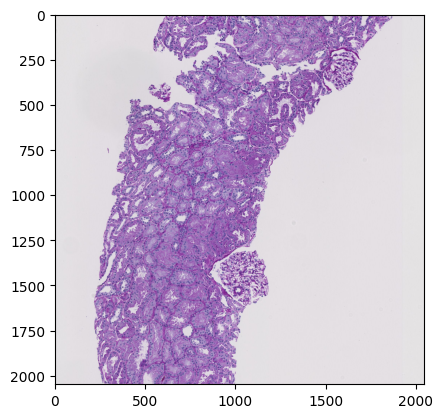

In [45]:
images, masks, weights= next(iter(tds))
plt.imshow(images)

tile retval <quickannotator.db.models.Tile object at 0x7feb22f099f0>
tile retval 2 <quickannotator.db.models.Tile object at 0x7feb22f099f0>
tile retval <quickannotator.db.models.Tile object at 0x7feb22f09150>
tile retval 2 <quickannotator.db.models.Tile object at 0x7feb22f09150>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


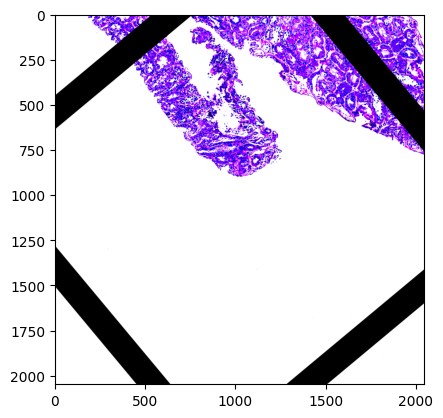

In [46]:
images, masks, weights = next(iter(dataloader))
i=images.cpu().detach()[0,::]
plt.imshow(i.squeeze().permute(1,2,0))


In [47]:
masks.max()

tensor(2, dtype=torch.uint8)

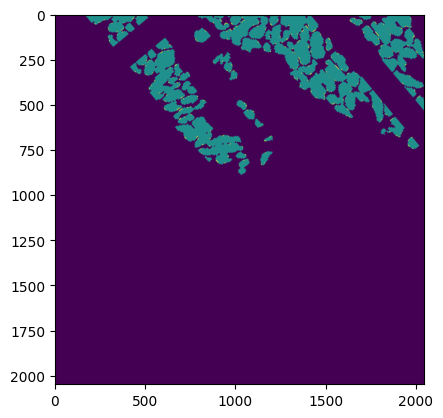

In [48]:
plt.imshow(masks[0,::].cpu().detach().squeeze())  

In [49]:
outputs = model(images.to(device))

In [50]:
o=torch.sigmoid(outputs.detach()).cpu()

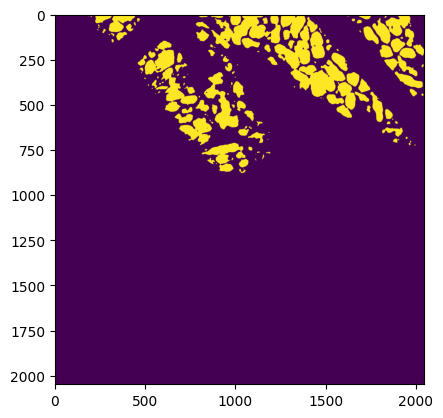

In [51]:
plt.imshow(o[0,::].squeeze()>.5)

(array([5934760.,  219322.,  179269.,  138903.,  137007.,  169358.,
         214789.,  278086.,  414517.,  702597.]),
 array([7.47246377e-04, 1.00629397e-01, 2.00511545e-01, 3.00393671e-01,
        4.00275826e-01, 5.00158012e-01, 6.00040138e-01, 6.99922323e-01,
        7.99804449e-01, 8.99686575e-01, 9.99568760e-01]),
 <BarContainer object of 10 artists>)

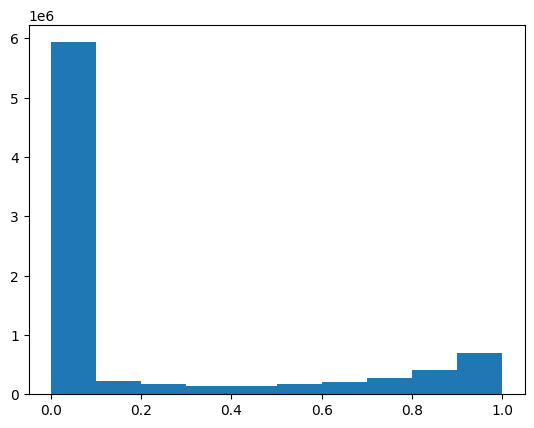

In [52]:
plt.hist(o.squeeze().numpy().flatten())

In [ ]:
masks

In [ ]:
o

In [ ]:
masks.shape